# Анализ данных в задаче кредитного скоринга

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import *
import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Считываем данные

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

### Задание 1

В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита (LIMIT_BAL) с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

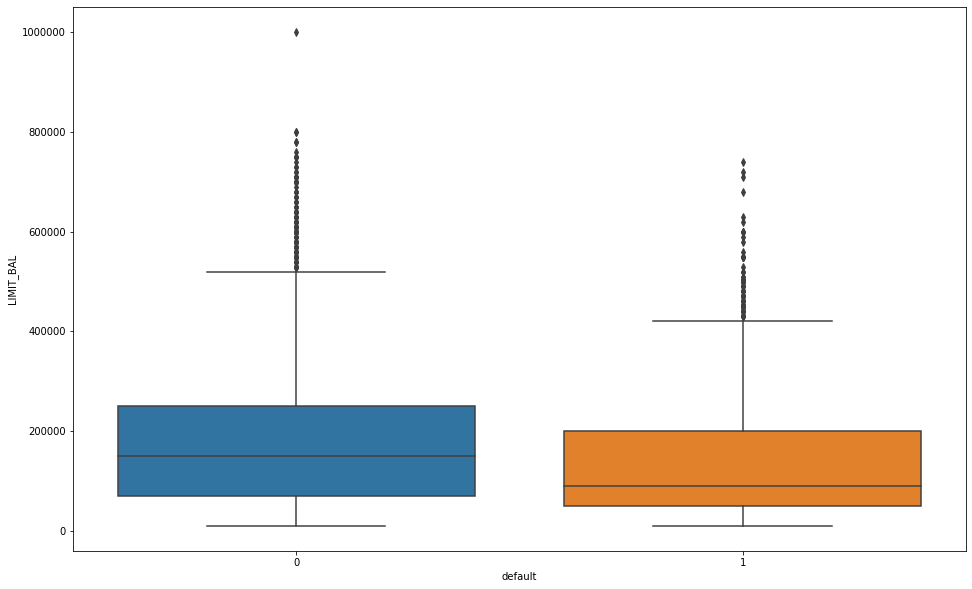

In [5]:
plt.figure(figsize(16,10))
sns.boxplot(x='default', y='LIMIT_BAL', data=data);

По графику boxplot можно увидеть, что средняя сумма выданного кредита больше у группы, которая в итоге кредиты отдавала. Также этой группе выдано больше кредитов выше определённой суммы (примерно 780к+).

Проверим гипотезу о медианных значениях с помощью бутстрепа.

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
good = data['LIMIT_BAL'][data.default == 0].values
bad = data['LIMIT_BAL'][data.default == 1].values

good_medians = list(map(np.median, get_bootstrap_samples(good, 2000)))
bad_medians = list(map(np.median, get_bootstrap_samples(bad, 2000)))

print("95% confidence interval of median for the good scores:",  stat_intervals(good_medians, 0.05))
print("95% confidence interval of median for the bad scores:",  stat_intervals(bad_medians, 0.05))

95% confidence interval of median for the good scores: [150000. 150000.]
95% confidence interval of median for the bad scores: [80000. 90000.]


Визуализируем распределения размера выданных кредитов для разных групп.

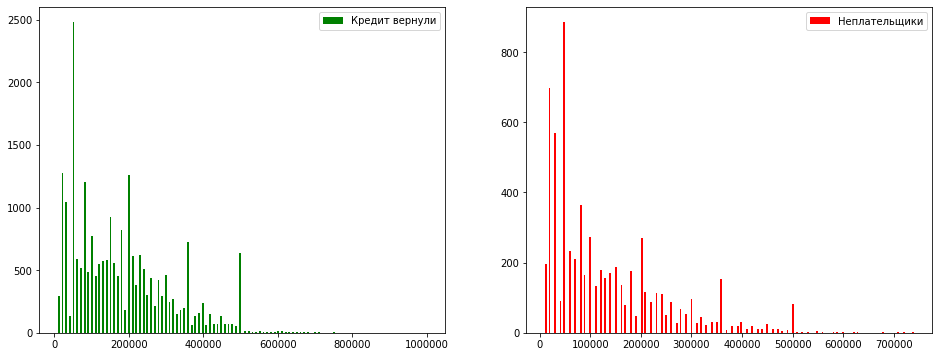

In [8]:
pylab.figure(figsize(16, 6))

pylab.subplot(1,2,1)
pylab.hist(good, bins=200, color='g', label='Кредит вернули')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(bad, bins=200, color='r', label='Неплательщики')
pylab.legend()

pylab.show()

Какое-то соответствие распределений есть, проверим формально.

#### Критерий Манна-Уитни.

Ограничения применимости:
* В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти. <b>Это выполняется</b>
* В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10). <b>Это нужно проверить</b>

In [9]:
print('Уникальных значений:', data['LIMIT_BAL'].nunique())
print('Количество объектов:', data['LIMIT_BAL'].shape[0])

Уникальных значений: 81
Количество объектов: 30000


Очевидно, что второе условие не выполняется, и критерий применять нельзя. Применим
#### перестановочный критерий.

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
print("p-value: %e" % permutation_test(good, bad, max_permutations = 1000))

p-value: 1.000000e-03


#### Выводы 1

a) 95% доверительные интервалы не пересекаются совсем, поэтому медианные значения двух групп не равны.

b) p-value перестановочного критерия меньше 0.05, поэтому мы отвергаем гипотезу об одинаковых распределениях.

С практической точки зрения готов сделать следующие выводы: меньшее среднее у людей, не возвращающих кредит, показывает, что изначально использованная система скоринга частично выполняет свою работу, выдавая кредиты меньшего размера потенциальным неплательщикам.

### Задание 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).

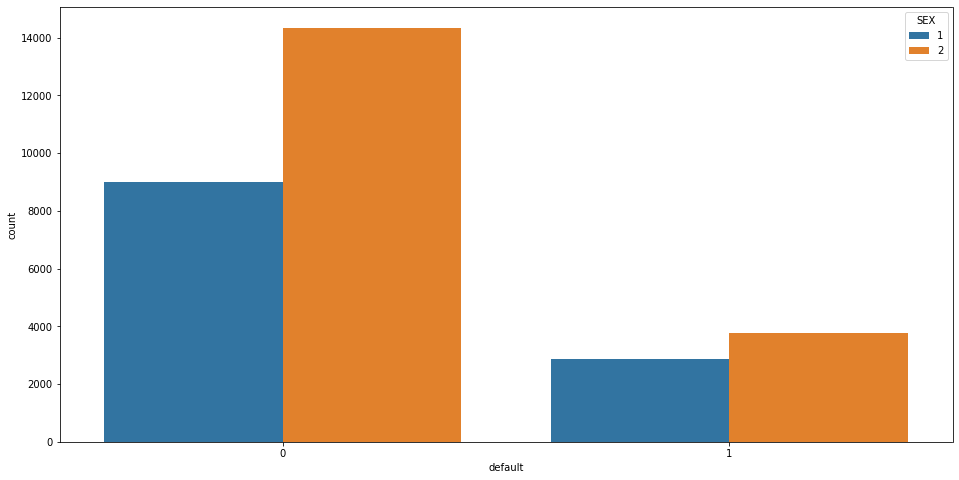

In [12]:
plt.figure(figsize=(16, 8))
sns.countplot(x='default', hue='SEX', data=data);

In [13]:
pd.crosstab(data['SEX'], data['default'])

default,0,1
SEX,,
1,9015,2873
2,14349,3763


Мы видим, что в нашей выборке женщин больше. Также на первый взгляд выше доля женщин в группе, вернувшей кредиты, в сравнении с другой группой.

Проверяем гипотезу, что гендерные доли одинаковы в выборках, разделённых по значению default, против гипотезы, что они отличаются.

Посчитаем доверительный интервал для разности долей на независимых выборках.

In [14]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [15]:
res = proportions_confint_diff_ind(data[data.default == 0]['SEX']-1, data[data.default == 1]['SEX']-1)
print(f'95% confidence interval of differences of women to men ratio between two groups: [{res[0]:.3f}, {res[1]:.3f}].')

95% confidence interval of differences of women to men ratio between two groups: [0.034, 0.061].


Мы видим, что ноль в доверительный интервал не входит, а это означает, что гендерный состав групп отличается. Решим ту же задачу с помощью Z-критерия для разности долей.

In [16]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sc.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sc.stats.norm.cdf(z_stat)

In [17]:
print("p-value: %e" % proportions_diff_z_test(proportions_diff_z_stat_ind(data[data.default == 0]['SEX']-1, data[data.default == 1]['SEX']-1)))

p-value: 4.472867e-12


#### Вывод 2

Итак, гипотеза о гендерном равенстве отвергнута двумя способами: доверительным интервалом и Z-критерием для разности долей (уровень значимости сильно меньше 0.05).

### Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? Наоборт, не отдаст долг?

In [18]:
pd.crosstab(data['EDUCATION'], data['default'])

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


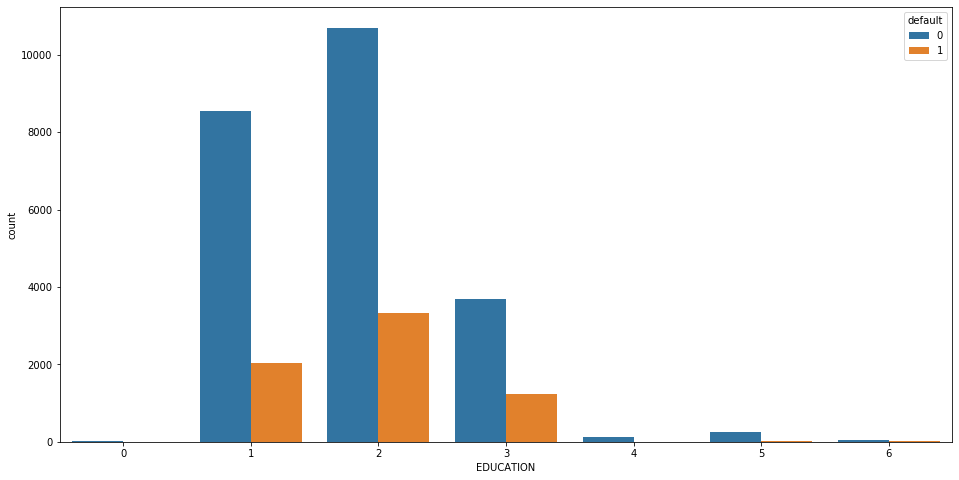

In [19]:
plt.figure(figsize=(16, 8))
sns.countplot(x='EDUCATION', hue='default', data=data);

По графику сложно увидеть какую-либо зависимость между переменными. Мы можем сделать вывод только о том, что у большинства людей есть хотя бы среднее образование.

Представим, что образование никак не влияет на возврат кредита. Тогда при любом образовании вероятность отдать кредит будет равна отношению количества отдавших на общее количество человек. Построим таблицу сопряжённости разницы в ожиданиях.

In [20]:
edu = pd.crosstab(data['EDUCATION'], data['default'])
edu.sum(axis=0)
expected = pd.DataFrame(np.round([edu.sum(axis=1) * edu.sum(axis=0)[0] / float(edu.sum().sum()),
                                  edu.sum(axis=1) * edu.sum(axis=0)[1] / float(edu.sum().sum())])).T
edudiff = edu-expected
edudiff

default,0,1
EDUCATION,,
0,3.0,-3.0
1,305.0,-305.0
2,-227.0,227.0
3,-149.0,149.0
4,20.0,-20.0
5,44.0,-44.0
6,3.0,-3.0


Сумма строк, очевидно, равна нулю, поэтому можно удалить один из столбцов без потери информации. Переведём его в проценты, которые покажут, на сколько больше людей отдали кредит в сравнении с ожидаемым количеством.

In [21]:
edudiff_scaled = edudiff[0] * 100 / edu[0]
edudiff_scaled

EDUCATION
0    21.428571
1     3.567669
2    -2.121495
3    -4.048913
4    17.241379
5    16.793893
6     6.976744
Name: 0, dtype: float64

Нагляднее будет отобразить эту разницу на графике.

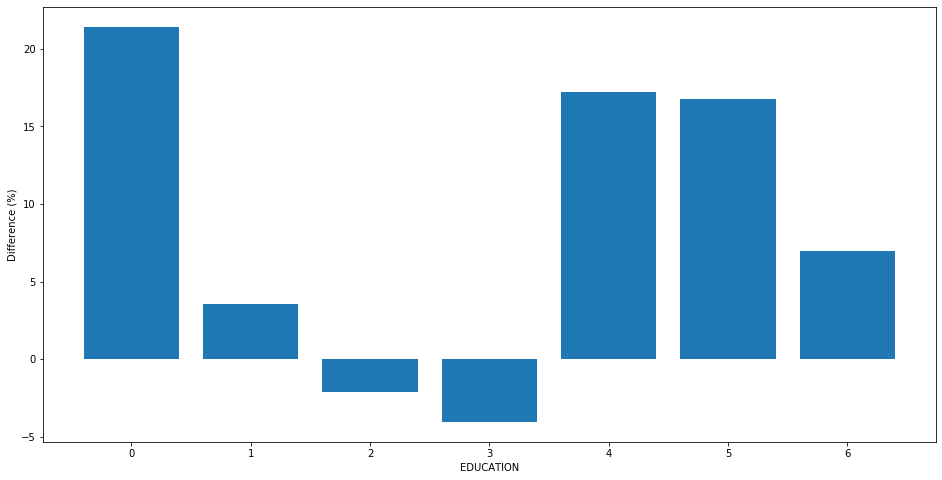

In [22]:
plt.figure(figsize=(16, 8))
x = [0, 1, 2, 3, 4, 5, 6]
plt.xlabel('EDUCATION')
plt.ylabel('Difference (%)')
plt.bar(x, edudiff_scaled);

Построим регрессию по default на все признаки. Мы знаем, что все значения вещественные. Проверим, есть ли пропуски:

In [23]:
data.isnull().values.any()

False

In [24]:
features = " + ".join(data.columns)
features = 'default ~ ' + features.replace(' + default','')
features

'default ~ ID + LIMIT_BAL + SEX + EDUCATION + MARRIAGE + AGE + PAY_0 + PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6 + BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6'

In [25]:
m1 = smf.ols(features, data=data)
fitted = m1.fit()
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


Сразу проверили критерием Бройша-Пагана: видим, что ошибка гетероскедастична. Перенастраиваем модель, учитывая это.

In [26]:
m2 = smf.ols(features, data=data)
fitted = m2.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     131.6
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:46:26   Log-Likelihood:                -13197.
No. Observations:               30000   AIC:                         2.644e+04
Df Residuals:                   29975   BIC:                         2.665e+04
Df Model:                          24                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2259      0.018     12.283      0.0

Отрицательный ненулевой коэффициент (-0.0095) означает, что образование влияет на возврат кредита. Кстати, в нашей модели оно соответствует 4.2% от самого большого по размеру коэффициента, так что нельзя сказать, что влияние значительное.
#### Вывод: чем хуже образование, тем выше вероятность невозврата кредита. Но влияние невысокое.

Докажем вышеизложенное формально, проверив гипотезу $H_{0}$: образование не влияет на возврат кредита против $H_{1}$: оно как-то влияет.

Используем <b>критерий хи-квадрат</b>. Сначала проверим, выполняются ли условия применения:
* Достаточно большая выборка (>40)
* Ячеек с количеством значений меньше 5 меньше 20%

В таблице сопряжённости на 14 ячеек только одна со значением меньше 5. Выборка же у нас размера 30000. Считаем коэффициент.

In [27]:
import scipy.stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2, p = ss.chi2_contingency(confusion_matrix)[0:2]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1))), p

In [28]:
cramers_coeff, p = cramers_corrected_stat(edu)
print('p-value = %e' % p)
print('Cramer V coefficient = %f' % cramers_coeff)

p-value = 1.233263e-32
Cramer V coefficient = 0.072393


p-value < 0.05, поэтому отвергаем нашу нулевую гипотезу. А коэффициент V Крамера меньше 0.1 показывает несушественную корреляцию.

### Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [29]:
marriage = pd.crosstab(data['MARRIAGE'], data['default'])
marriage

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


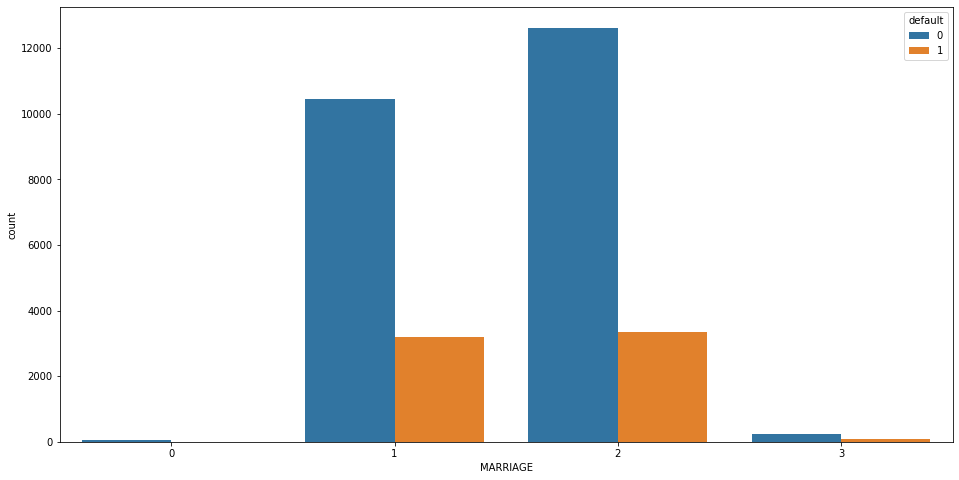

In [30]:
plt.figure(figsize=(16, 8))
sns.countplot(x='MARRIAGE', hue='default', data=data);

По графику понятно немногое: <b>холостые чуть чаще возвращают кредит, чем женатые</b>. Других данных очень мало.

Так как MARRIAGE является категориальной переменной, в качестве меры выберем <b>коэффициент V Крамера</b>. Напомню условия применения (одновременно проверяем нулевую гипотезу об отсутствии связи по критерию хи-квадрат):
* Достаточно большая выборка (>40)
* Ячеек с количеством значений меньше 5 меньше 20%

Простой взгляд на таблицу сопряжённости показывает, что условия выполняются. Считаем коэффициент.

In [31]:
cramers_coeff2, p2 = cramers_corrected_stat(marriage)
print('p-value = %e' % p2)
print('Cramer V coefficient = %f' % cramers_coeff2)

p-value = 8.825862e-08
Cramer V coefficient = 0.032997


По критерию хи-квадрат нулевая гипотеза отвергается, по коэффициенту Крамера корреляция есть, но несущественная.

### Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

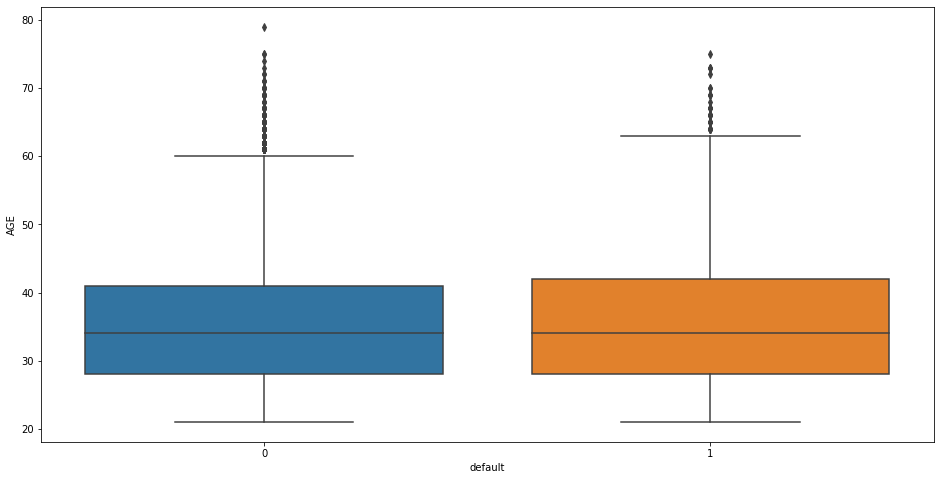

In [32]:
plt.figure(figsize(16,8))
sns.boxplot(x='default', y='AGE', data=data);

График boxplot показывает неразличимые на глаз значения медиан. Теперь посмотрим на распределения: они тоже похожи, имеет смысл проверить гипотезу об их равенстве.

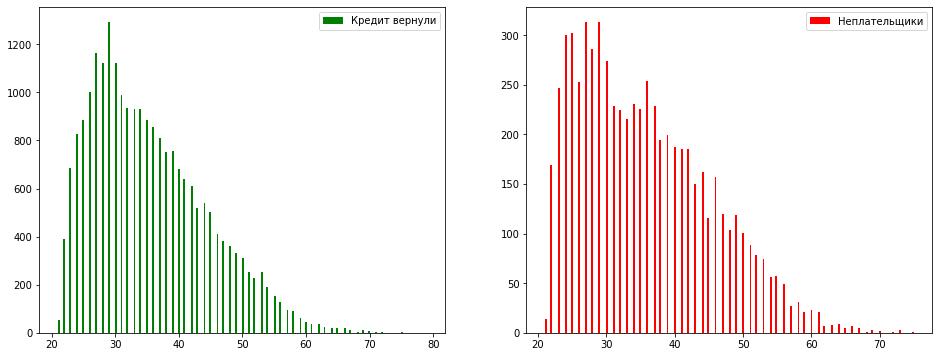

In [33]:
good_age = data['AGE'][data.default == 0].values
bad_age = data['AGE'][data.default == 1].values

pylab.figure(figsize(16, 6))

pylab.subplot(1,2,1)
pylab.hist(good_age, bins=200, color='g', label='Кредит вернули')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(bad_age, bins=200, color='r', label='Неплательщики')
pylab.legend()

pylab.show()

Повторяем те же действия, что и в первом пункте. Проверим гипотезу о равенстве медиан через бутстреп и доверительные интервалы.

In [34]:
good_age_medians = list(map(np.median, get_bootstrap_samples(good_age, 2000)))
bad_age_medians = list(map(np.median, get_bootstrap_samples(bad_age, 2000)))

print("95% confidence interval of AGE median for the good scores:",  stat_intervals(good_age_medians, 0.05))
print("95% confidence interval of AGE median for the bad scores:",  stat_intervals(bad_age_medians, 0.05))

95% confidence interval of AGE median for the good scores: [34. 34.]
95% confidence interval of AGE median for the bad scores: [34. 35.]


Итак, гипотезу на уровне значимости 0.05 отвергнуть нельзя, так как интервалы пересекаются. Теперь проверим гипотезу о равенстве распределений с помощью перестановочного критерия.

In [35]:
print("p-value: %f" % permutation_test(good_age, bad_age, max_permutations = 1000))

p-value: 0.011000


И всё-таки на уровне значимости 0.05 мы отвергаем гипотезу, что распределения похожи. Практические результаты наших исследований: <b>возврат кредита практически не зависит от возвраста</b>. Данная информация может остановить предвзятость в выдачах кредитов для молодых и старых соискателей.